In [502]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
import random

## Z-score

In [503]:
def zScoreScale(x):
    data = x
    mean = data.mean()
    sig = np.sqrt(((data - mean)**2).sum())
    scaled_x = np.zeros(x.shape)
    
    scaled_data = (data - mean)/sig
    for i in range(x.shape[1]):
        scaled_x[:,i] = scaled_data[:,i]
    return scaled_x, mean, sig

def zScoreDescale(x, mean, sig):
    scaled_data = x
    descaled_data = scaled_data * sig + mean
    
    descaled_x = np.zeros(x.shape)
    for i in range(x.shape[1]):
        descaled_x[:,i] = descaled_data[:,i]
        
    return descaled_x

## Min Max

In [504]:
def minMaxScale(data):
    min_value = np.min(data)
    max_value = np.max(data)
    normalized_data = (data - min_value)/(max_value - min_value)
    
    return normalized_data, min_value, max_value

def minMaxDescale(normalized_data, min_value, max_value):
    
    denormalized_data = (normalized_data * (max_value - min_value)) + min_value
    
    return denormalized_data

## Redes neurais

In [505]:
class TanhRegressionNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TanhRegressionNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        hidden_output = self.tanh(self.hidden(x))
        output = self.output(hidden_output)
        return output

    def train_self(self, x_train, y_train, learning_rate=0.001, momentum=0.9, weight_decay=0.001, num_epochs=250, batch_size=32):
        optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        loss_values = np.zeros((3, num_epochs))
        criterion = nn.MSELoss()

        for epoch in range(num_epochs):
            self.train()
            indices = torch.randperm(x_train.shape[0])
            x_it = x_train[indices]
            y_it = y_train[indices]

            for i in range(0, x_it.shape[0], batch_size):
                inputs = x_it[i:i + batch_size]
                targets = y_it[i:i + batch_size]

                optimizer.zero_grad()

                output = self(inputs)
                loss = criterion(output, targets)

                loss.backward()
                optimizer.step()

            self.eval()
            y_pred = self(x_train)
            mse = criterion(y_pred, y_train)
            rmse = np.sqrt(float(mse))
            

            MAE_fn = nn.L1Loss()
            mae = MAE_fn(y_pred, y_train)

            mare = mean_absolute_percentage_error(y_pred.detach().numpy(), y_train.detach().numpy())
            mare /= 100

            loss_values[0, epoch] = rmse
            loss_values[1, epoch] = mae
            loss_values[2, epoch] = mare

        return loss_values
        

In [506]:
class ReLUClassificationNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ReLUClassificationNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        hidden_output = self.relu(self.hidden(x))
        output = self.output(hidden_output)
        return output
    
    def train_self(self, x_train, y_train, learning_rate=0.001, momentum=0.9, weight_decay=0.001, num_epochs =250, batch_size = 32):
        optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        loss_values = np.zeros((2, num_epochs))
        criterion = nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            self.train()
            indices = torch.randperm(x_train.shape[0])
            x_it = x_train[indices]
            y_it = y_train[indices]

            for i in range (0, x_it.shape[0], batch_size):
                inputs = x_it[i:i+batch_size]
                targets = y_it[i:i+batch_size]

                optimizer.zero_grad()

                output = self(inputs)
                loss = criterion(output, targets)

                loss.backward()
                optimizer.step()

            self.eval()
            y_pred = self(x_train)
            ce = float(criterion(y_pred, y_train))
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_train, 1)).float().mean()

            loss_values[0, epoch] = ce
            loss_values[1, epoch] = acc
        
        return loss_values

## Random Search

In [507]:
def random_search_tanh(x, y, x_validation, y_validation, num_models = 10, num_epochs = 250):
    best_loss = float('inf')
    best_hyperparameters = None
    input_size = 8
    output_size = 1
    model_info = []
    criterion = nn.MSELoss()

    for i in range(num_models):
        # Generate random hyperparameters
        hidden_size = random.choice([16, 32, 64, 128])
        learning_rate = random.uniform(0.00001, 0.01)
        weight_decay = random.uniform(0.00001, 0.01)
        momentum = random.uniform(0.5, 0.99)
        batch_size = random.choice([16, 32, 64, 128])

        hyperparameters = (hidden_size, learning_rate, weight_decay, momentum, batch_size)

        # Create the neural network with the random hyperparameters
        network = TanhRegressionNeuralNetwork(input_size, hidden_size, output_size)


        # Train the network and get the loss values
        loss_values = network.train_self(x, 
                                         y, 
                                         learning_rate = learning_rate, 
                                         weight_decay = weight_decay,
                                         momentum = momentum, 
                                         num_epochs = num_epochs, 
                                         batch_size = batch_size)

        regressor.eval()
        # Get the final loss value
        loss = criterion(network(x_validation), y_validation).item()
        rmse_loss = np.sqrt(loss)
        model_info.append([rmse_loss, hyperparameters])

        # Check if the current hyperparameters are the best
        if loss < best_loss:
            best_loss = rmse_loss
            best_hyperparameters = hyperparameters
            best_loss_values = loss_values
        
        print("-------------- Modelo", i + 1, "--------------")
        print("RMSE =", rmse_loss)
        print("Hidden layer neurons =", hidden_size)
        print("Learning rate =", learning_rate)
        print("Weight Decay =", weight_decay)
        print("Momentum =", momentum)
        print("Batch size =", batch_size)
        print("")
    
    return best_hyperparameters, best_loss, model_info, best_loss_values

In [508]:
def random_search_relu(x, y, x_validation, y_validation, num_models = 10, num_epochs = 250):
    best_loss = float('inf')
    best_acc = - float('inf')
    best_hyperparameters = None
    input_size = x.shape[1]
    output_size = 11
    model_info = []
    criterion = nn.CrossEntropyLoss()

    for i in range(num_models):
        # Generate random hyperparameters
        hidden_size = random.choice([16, 32, 64, 128])
        learning_rate = random.uniform(0.00001, 0.01)
        weight_decay = random.uniform(0.00001, 0.01)
        momentum = random.uniform(0.5, 0.99)
        batch_size = random.choice([16, 32, 64, 128])

        hyperparameters = (hidden_size, 
                           learning_rate, 
                           weight_decay, 
                           momentum, 
                           batch_size)

        # Create the neural network with the random hyperparameters
        network = ReLUClassificationNeuralNetwork(input_size, hidden_size, output_size)


        # Train the network and get the loss values
        loss_values = network.train_self(x, 
                                         y, 
                                         learning_rate = learning_rate, 
                                         weight_decay = weight_decay,
                                         momentum = momentum, 
                                         num_epochs = num_epochs, 
                                         batch_size = batch_size)

        regressor.eval()
        # Get the final loss value
        y_pred = network(x_validation)
        ce_loss = criterion(y_pred, y_validation).item()
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_validation, 1)).float().mean().item()
        model_info.append([acc, hyperparameters])

        # Check if the current hyperparameters are the best
        if acc > best_acc:
            best_loss = ce_loss
            best_acc = acc
            best_hyperparameters = hyperparameters
            best_loss_values = loss_values
        
        print("-------------- Modelo", i + 1, "--------------")
        print("Cross Entropy =", ce_loss)
        print("Accuracy =", acc)
        print("Hidden layer neurons =", hidden_size)
        print("Learning rate =", learning_rate)
        print("Weight Decay =", weight_decay)
        print("Momentum =", momentum)
        print("Batch size =", batch_size)
        print("")
    
    return best_hyperparameters, best_acc, best_loss, model_info, best_loss_values

## Questão 1

### Preparação dos dados

In [509]:
data = np.genfromtxt("concrete.csv", delimiter=',')

np.random.shuffle(data)
normalized_data, min_value, max_value = minMaxScale(data)

# Índices
train_index = (int) (np.floor(data.shape[0] * 0.6))
validation_index = (int) (np.floor(data.shape[0] * 0.8))

# Conjuntos de treino
train_x = torch.Tensor(data[:train_index, :8]).float()
train_y = torch.tensor(data[:train_index, 8].reshape(-1,1)).float()

normalized_train_x = torch.Tensor(normalized_data[:train_index, :8]).float()
normalized_train_y = torch.tensor(normalized_data[:train_index, 8].reshape(-1,1)).float()

# Conjuntos de validação
validation_x = torch.Tensor(data[train_index:validation_index, :8]).float()
validation_y = torch.Tensor(data[train_index:validation_index, 8].reshape(-1,1)).float()

normalized_validation_x = torch.Tensor(normalized_data[train_index:validation_index, :8]).float()
normalized_validation_y = torch.Tensor(normalized_data[train_index:validation_index, 8].reshape(-1,1)).float()

# Conjuntos de teste
test_x = torch.Tensor(data[validation_index:, :8]).float()
test_y = torch.Tensor(data[validation_index:, 8].reshape(-1,1)).float()

normalized_test_x = torch.Tensor(normalized_data[validation_index:, :8]).float()
normalized_test_y = torch.Tensor(normalized_data[validation_index:, 8].reshape(-1,1)).float()

# Conjuntos de treino finais (treino + validação)
final_train_x = torch.Tensor(data[:validation_index, :8]).float()
final_train_y = torch.Tensor(data[:validation_index, 8]).float()

normalized_final_train_x = torch.Tensor(normalized_data[:validation_index, :8]).float()
normalized_final_train_y = torch.Tensor(normalized_data[:validation_index, 8].reshape(-1,1)).float()

### Encontrar hiperparâmetros via Random Search

In [510]:
hyperparameters, loss, model_info, training_loss = random_search_tanh(normalized_train_x, 
                                                                         normalized_train_y, 
                                                                         normalized_validation_x, 
                                                                         normalized_validation_y,
                                                                         num_models = 10,
                                                                         num_epochs = 400)

-------------- Modelo 1 --------------
RMSE = 0.014242794855470043
Hidden layer neurons = 64
Learning rate = 0.001422807593634927
Weight Decay = 0.008929080491468186
Momentum = 0.6327851465777012
Batch size = 128

-------------- Modelo 2 --------------
RMSE = 0.012139567274450317
Hidden layer neurons = 128
Learning rate = 0.0056357070185179435
Weight Decay = 0.0076076262524622925
Momentum = 0.7929112135699148
Batch size = 64

-------------- Modelo 3 --------------
RMSE = 0.011969735294292795
Hidden layer neurons = 128
Learning rate = 0.0009593324591930531
Weight Decay = 0.009904210194039448
Momentum = 0.7848717129490621
Batch size = 16

-------------- Modelo 4 --------------
RMSE = 0.015317176213845714
Hidden layer neurons = 16
Learning rate = 0.009622945711055693
Weight Decay = 0.009515113982625919
Momentum = 0.9892656193424749
Batch size = 64

-------------- Modelo 5 --------------
RMSE = 0.012769435711766112
Hidden layer neurons = 64
Learning rate = 0.008737949413086555
Weight Decay

CONSULTE A TABELA NA CÉLULA ACIMA PARA VER OS HIPERPARÂMETROS DE CADA MODELO


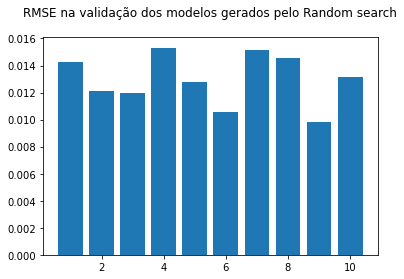

In [511]:
print('CONSULTE A TABELA NA CÉLULA ACIMA PARA VER OS HIPERPARÂMETROS DE CADA MODELO')
labels = np.arange(len(model_info)) + 1
values = []
for (loss, hyper) in model_info:
    values.append(loss)

plt.title('RMSE na validação dos modelos gerados pelo Random search\n')
plt.bar(labels, values, align='center')
plt.show()

In [512]:
print('Melhores hiperparâmetros: ')
print("Hidden layer neurons =", hyperparameters[0])
print("Learning rate =", hyperparameters[1])
print("Weight Decay =", hyperparameters[2])
print("Momentum =", hyperparameters[3])
print("Batch size =", hyperparameters[4])
print("")

Melhores hiperparâmetros: 
Hidden layer neurons = 16
Learning rate = 0.0038684700542396897
Weight Decay = 0.001978146846545491
Momentum = 0.5786780441765597
Batch size = 32



### Treinar Rede neural final com hiperparâmetros obtidos

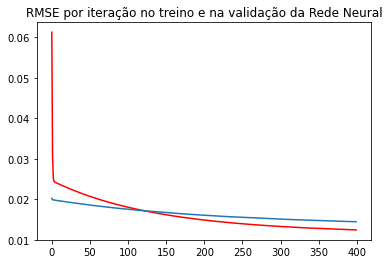

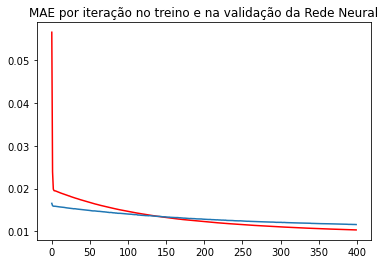

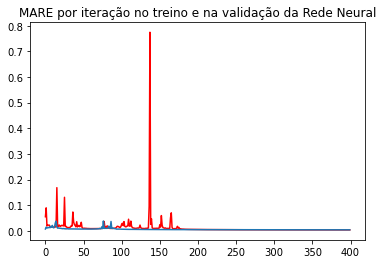

RMSE no teste: 0.015244539760121115
MAE no teste: 0.01219429075717926
MARE no teste: 0.004061093032360077


In [513]:
regressor = TanhRegressionNeuralNetwork(8, hyperparameters[0], 1)

test_loss = regressor.train_self(normalized_final_train_x, 
                                 normalized_final_train_y, 
                                 num_epochs=400, 
                                 learning_rate=hyperparameters[1], 
                                 weight_decay=hyperparameters[2], 
                                 momentum=hyperparameters[3], 
                                 batch_size=hyperparameters[4])

# Calcula os erros no teste
regressor.eval()
y_pred = regressor(normalized_test_x)
lossFunction = nn.MSELoss()

test_rmse = np.sqrt(lossFunction(y_pred, normalized_test_y).item())

lossFunction = nn.L1Loss()

test_mae = lossFunction(y_pred, normalized_test_y).item()

test_mare = mean_absolute_percentage_error(y_pred.detach().numpy(), normalized_test_y.detach().numpy())
test_mare /= 100



# Plota os erros no treino e validação
plt.title("RMSE por iteração no treino e na validação da Rede Neural")
plt.plot(np.arange(training_loss.shape[1]), training_loss[0], color='red', label='Treino')
plt.plot(np.arange(test_loss.shape[1]), test_loss[0], label='Validação')
plt.show()

plt.title("MAE por iteração no treino e na validação da Rede Neural")
plt.plot(np.arange(training_loss.shape[1]), training_loss[1], color='red', label="Treino")
plt.plot(np.arange(test_loss.shape[1]), test_loss[1], label='Validação')
plt.show()

plt.title("MARE por iteração no treino e na validação da Rede Neural")
plt.plot(np.arange(training_loss.shape[1]), training_loss[2], color='red', label="Treino")
plt.plot(np.arange(test_loss.shape[1]), test_loss[2], label='Validação')
plt.show()

# Printa os erros no teste
print("RMSE no teste:", test_rmse)
print("MAE no teste:", test_mae)
print("MARE no teste:", test_mare)

## Questão 2

### Preparação dos dados

In [514]:
data = np.genfromtxt("vowel.csv", delimiter=',')
np.random.shuffle(data)

x = torch.Tensor(data[:, :10])
y = torch.Tensor(data[:, 10].reshape(-1, 1))

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y)
one_hot_y = torch.tensor(enc.transform(y).toarray())

# Índices

train_index = (int) (np.floor(data.shape[0] * 0.6))
validation_index = (int) (np.floor(data.shape[0] * 0.8))

# Conjuntos de treino
train_x = torch.Tensor(x[:train_index, :10]).float()
train_y = torch.tensor(one_hot_y[:train_index, :])

# Conjuntos de validação
validation_x = torch.Tensor(data[train_index:validation_index, :10]).float()
validation_y = torch.Tensor(one_hot_y[train_index:validation_index, :])

# Conjuntos de teste
test_x = torch.Tensor(data[validation_index:, :10]).float()
test_y = torch.Tensor(one_hot_y[validation_index:, :]).long()

# Conjuntos de treino finais (treino + validação)
final_train_x = torch.Tensor(data[:validation_index, :10]).float()
final_train_y = torch.Tensor(one_hot_y[:validation_index, :])

/tmp/ipykernel_2379/3034839501.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(one_hot_y[:train_index, :])


### Encontrar melhores hiperparâmetros via Random Search

In [515]:
hyperparameters, acc, loss, model_info, training_loss = random_search_relu(train_x, 
                                                                           train_y, 
                                                                           validation_x, 
                                                                           validation_y,
                                                                           num_models = 10,
                                                                           num_epochs = 400)

-------------- Modelo 1 --------------
Cross Entropy = 0.6078874499200739
Accuracy = 0.7676767706871033
Hidden layer neurons = 32
Learning rate = 0.008383162971878863
Weight Decay = 0.003659300815419014
Momentum = 0.9263250798596674
Batch size = 128

-------------- Modelo 2 --------------
Cross Entropy = 0.9984348613411339
Accuracy = 0.6363636255264282
Hidden layer neurons = 32
Learning rate = 0.005184244191716444
Weight Decay = 0.007940432652536909
Momentum = 0.8217818617798227
Batch size = 64

-------------- Modelo 3 --------------
Cross Entropy = 0.2951387971333859
Accuracy = 0.8888888955116272
Hidden layer neurons = 32
Learning rate = 0.009145945756923606
Weight Decay = 0.0008296730518998271
Momentum = 0.9855007579562404
Batch size = 128

-------------- Modelo 4 --------------
Cross Entropy = 0.5111686979312299
Accuracy = 0.8131313323974609
Hidden layer neurons = 64
Learning rate = 0.009996604078756684
Weight Decay = 0.003984481731996828
Momentum = 0.6739304166172264
Batch size = 1

CONSULTE A TABELA NA CÉLULA ACIMA PARA VER OS HIPERPARÂMETROS DE CADA MODELO


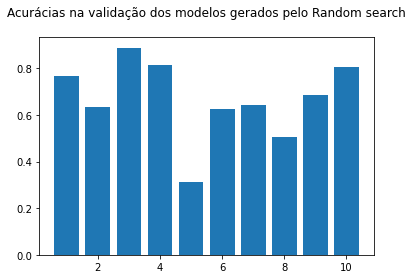

In [516]:
print('CONSULTE A TABELA NA CÉLULA ACIMA PARA VER OS HIPERPARÂMETROS DE CADA MODELO')
labels = np.arange(len(model_info)) + 1
values = []
for (acc, hyper) in model_info:
    values.append(acc)

plt.title('Acurácias na validação dos modelos gerados pelo Random search\n')
plt.bar(labels, values, align='center')
plt.show()

In [517]:
print('Melhores hiperparâmetros: ')
print("Hidden layer neurons =", hyperparameters[0])
print("Learning rate =", hyperparameters[1])
print("Weight Decay =", hyperparameters[2])
print("Momentum =", hyperparameters[3])
print("Batch size =", hyperparameters[4])
print("")

Melhores hiperparâmetros: 
Hidden layer neurons = 32
Learning rate = 0.009145945756923606
Weight Decay = 0.0008296730518998271
Momentum = 0.9855007579562404
Batch size = 128



### Treinar rede neural final com os hiperparâmetros obtidos

In [518]:
classificador = ReLUClassificationNeuralNetwork(x.shape[1], 16, 11)

loss = classificador.train_self(final_train_x, 
                                final_train_y, 
                                num_epochs=400, 
                                learning_rate=hyperparameters[1], 
                                weight_decay=hyperparameters[2], 
                                momentum=hyperparameters[3], 
                                batch_size=hyperparameters[4])

# Calcula a cross entropia e a acurácia no teste
classificador.eval()
ce_fn = nn.CrossEntropyLoss()
y_pred = clasisficador(test_x)

ce_final = float(ce_fn(y_pred, y_train))
acc_final = (torch.argmax(y_pred, 1) == torch.argmax(y_train, 1)).float().mean()

# Plota os gráficos da cross entropia e acurácia no treino e validação
plt.title("CEL por iteração na validação da Rede Neural")
plt.plot(np.arange(training_loss.shape[1]), training_loss[0], color='red', label="Treino")
plt.plot(np.arange(loss.shape[1]), loss[0], label="Validação")
plt.show()

plt.title("Acurácia por iteração na validação da Rede Neural")
plt.plot(np.arange(training_loss.shape[1]), training_loss[1], color='red', label="Treino")
plt.plot(np.arange(loss.shape[1]), loss[1], label="Validação")
plt.show()

# Printa a cross entropia e a acurácia no teste
print("Cross entropy no teste:", ce_final)
print("Acurácia no teste:", acc_final)

NameError: name 'clasisficador' is not defined